# Country Clustering — EDA, K-Means, Hierárquico e K-Medóides

In [1]:
import sys, platform, numpy, pandas, sklearn, scipy, matplotlib, seaborn
print("Platform:", platform.platform())
print("Python:", sys.version)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("scikit-learn:", sklearn.__version__)
print("scipy:", scipy.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)

Platform: macOS-10.16-x86_64-i386-64bit
Python: 3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]
numpy: 1.26.4
pandas: 2.2.2
scikit-learn: 1.5.1
scipy: 1.13.1
matplotlib: 3.8.4
seaborn: 0.13.2


## Parte 2 — Carregamento e EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA_PATH = Path("../data/Country-data.csv").resolve()
df = pd.read_csv(DATA_PATH)
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [16]:
# Informações gerais
display(df.info())
display(df.describe(include='all').T)

# Quantidade de países
num_countries = df['country'].nunique() if 'country' in df.columns else df.shape[0]
print("Quantidade de países no dataset:", num_countries)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,167,167,Afghanistan,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
child_mort,167.0,NaN,NaN,NaN,38.27006,40.328931,2.6,8.25,19.3,62.1,208.0
exports,167.0,NaN,NaN,NaN,41.108976,27.41201,0.109,23.8,35.0,51.35,200.0
health,167.0,NaN,NaN,NaN,6.815689,2.746837,1.81,4.92,6.32,8.6,17.9
imports,167.0,NaN,NaN,NaN,46.890215,24.209589,0.0659,30.2,43.3,58.75,174.0
income,167.0,NaN,NaN,NaN,17144.688623,19278.067698,609.0,3355.0,9960.0,22800.0,125000.0
inflation,167.0,NaN,NaN,NaN,7.781832,10.570704,-4.21,1.81,5.39,10.75,104.0
life_expec,167.0,NaN,NaN,NaN,70.555689,8.893172,32.1,65.3,73.1,76.8,82.8
total_fer,167.0,NaN,NaN,NaN,2.947964,1.513848,1.15,1.795,2.41,3.88,7.49
gdpp,167.0,NaN,NaN,NaN,12964.155689,18328.704809,231.0,1330.0,4660.0,14050.0,105000.0


Quantidade de países no dataset: 167


In [17]:
# Verificar valores ausentes
df_nulls = df.isna().sum().sort_values(ascending=False)
df_nulls

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

### Faixa dinâmica das variáveis numéricas

In [18]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
ranges = pd.DataFrame({
    'min': df[numeric_cols].min(),
    'max': df[numeric_cols].max(),
    'range': df[numeric_cols].max() - df[numeric_cols].min(),
    'std': df[numeric_cols].std()
}).sort_values('range', ascending=False)
ranges

,min,max,range,std
income,609.0000,125000.00,124391.0000,19278.067698
gdpp,231.0000,105000.00,104769.0000,18328.704809
child_mort,2.6000,208.00,205.4000,40.328931
exports,0.1090,200.00,199.8910,27.412010
imports,0.0659,174.00,173.9341,24.209589
inflation,-4.2100,104.00,108.2100,10.570704
life_expec,32.1000,82.80,50.7000,8.893172
health,1.8100,17.90,16.0900,2.746837
total_fer,1.1500,7.49,6.3400,1.513848


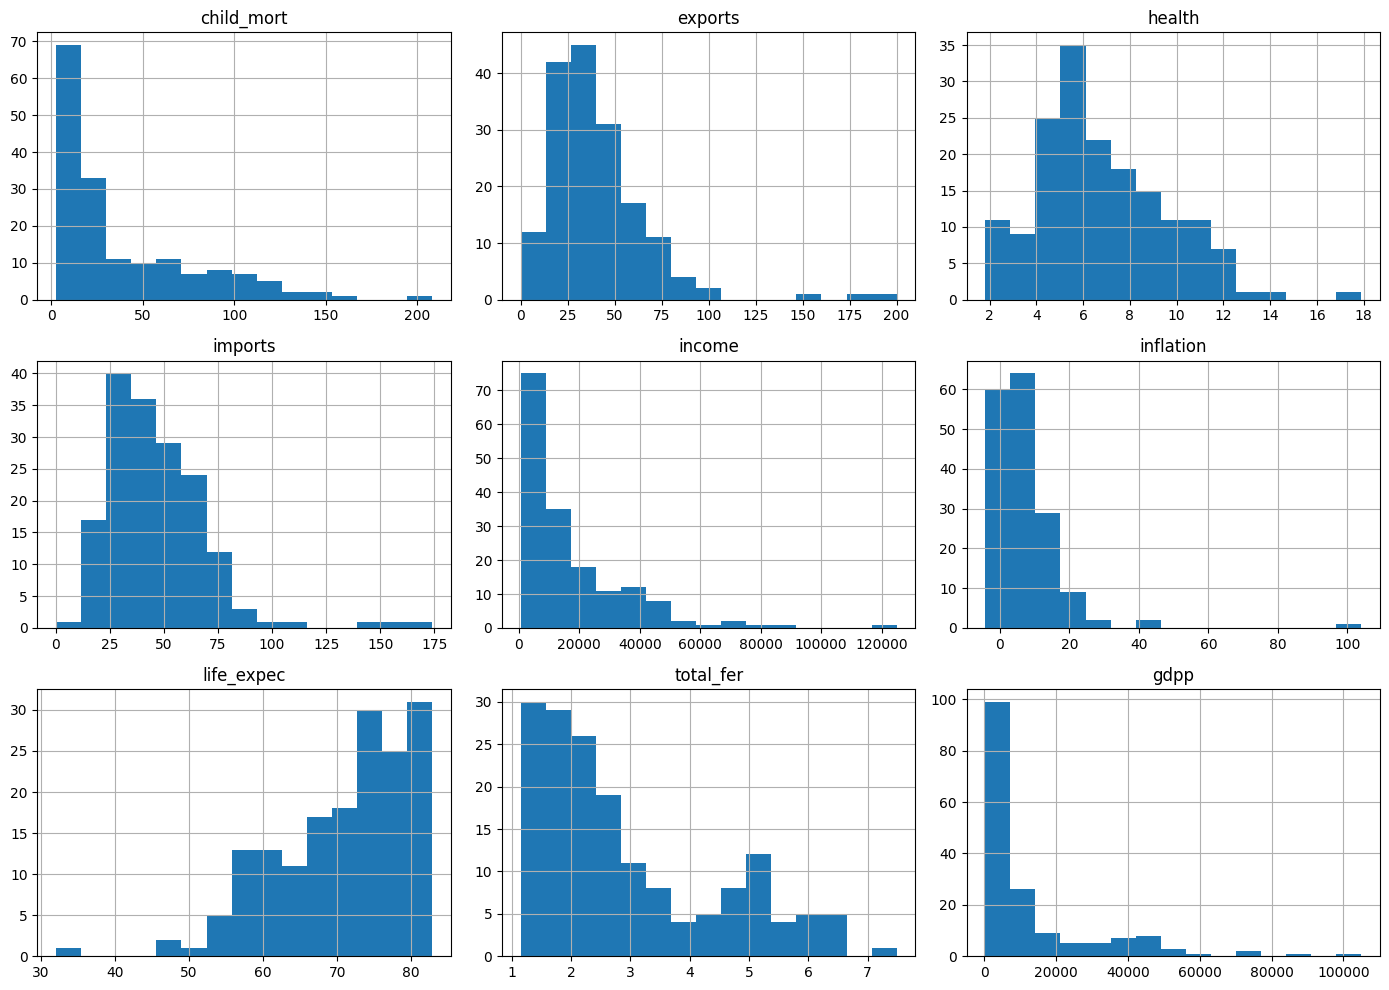

In [19]:
# Visualizações de distribuição
_ = df[numeric_cols].hist(bins=15, figsize=(14, 10))
plt.tight_layout()
plt.show()

## Pré-processamento (Parte 2)
- Remover coluna de identificador (`country`) para modelagem, mantendo-a à parte.
- Preencher eventuais *NaNs* (se existirem) — aqui optamos por `median`.
- Padronizar com `StandardScaler`.

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

id_col = 'country' if 'country' in df.columns else None
X_raw = df.drop(columns=[id_col]) if id_col else df.copy()

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_raw)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

countries = df[id_col].values if id_col else np.arange(df.shape[0])
X_scaled[:3], countries[:3]

(array([[ 1.29153238, -1.13827979,  0.27908825, -0.08245496, -0.8082454 ,
          0.15733622, -1.61909203,  1.90288227, -0.67917961],
        [-0.5389489 , -0.47965843, -0.09701618,  0.07083669, -0.3753689 ,
         -0.31234747,  0.64786643, -0.85997281, -0.48562324],
        [-0.27283273, -0.09912164, -0.96607302, -0.64176233, -0.22084447,
          0.78927429,  0.67042323, -0.0384044 , -0.46537561]]),
 array(['Afghanistan', 'Albania', 'Algeria'], dtype=object))

## Parte 3 — Clusterização (K=3)
### 3.1 K-Means

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

k = 3
kmeans = KMeans(n_clusters=k, n_init=30, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)
sil_km = silhouette_score(X_scaled, labels_km)
print("Silhouette (K-Means, k=3):", round(sil_km, 4))

Silhouette (K-Means, k=3): 0.2833


In [22]:
# País representativo de cada cluster = país mais próximo ao centróide
from numpy.linalg import norm

centroids = kmeans.cluster_centers_
repr_countries = []
for i in range(k):
    idxs = np.where(labels_km == i)[0]
    dists = [norm(X_scaled[j] - centroids[i]) for j in idxs]
    j_min = idxs[int(np.argmin(dists))]
    repr_countries.append((i, countries[j_min], float(np.min(dists)), len(idxs)))

repr_countries

[(0, 'Iceland', 0.7317641998178884, 36),
 (1, 'Guinea', 0.8290878087807008, 47),
 (2, 'Jamaica', 0.7343794698368828, 84)]

In [23]:
# Distribuição das dimensões em cada cluster (médias padronizadas)
import pandas as pd
cluster_profiles = (
    pd.DataFrame(X_scaled, columns=[c for c in X_raw.columns])
    .assign(cluster=labels_km)
    .groupby('cluster').mean()
)
cluster_sizes = pd.Series(labels_km).value_counts().sort_index()
display(cluster_sizes.rename("cluster_size"))
display(cluster_profiles.style.background_gradient(cmap="coolwarm"))

0    36
1    47
2    84
Name: cluster_size, dtype: int64

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,-0.827449,0.645080,0.727411,0.190639,1.484243,-0.484921,1.079579,-0.791877,1.615995
1,1.360218,-0.437533,-0.155984,-0.189204,-0.686894,0.402111,-1.282180,1.364944,-0.604242
2,-0.406453,-0.031653,-0.224471,0.024162,-0.251770,-0.017167,0.254734,-0.424343,-0.354481


### 3.2 Clusterização Hierárquica

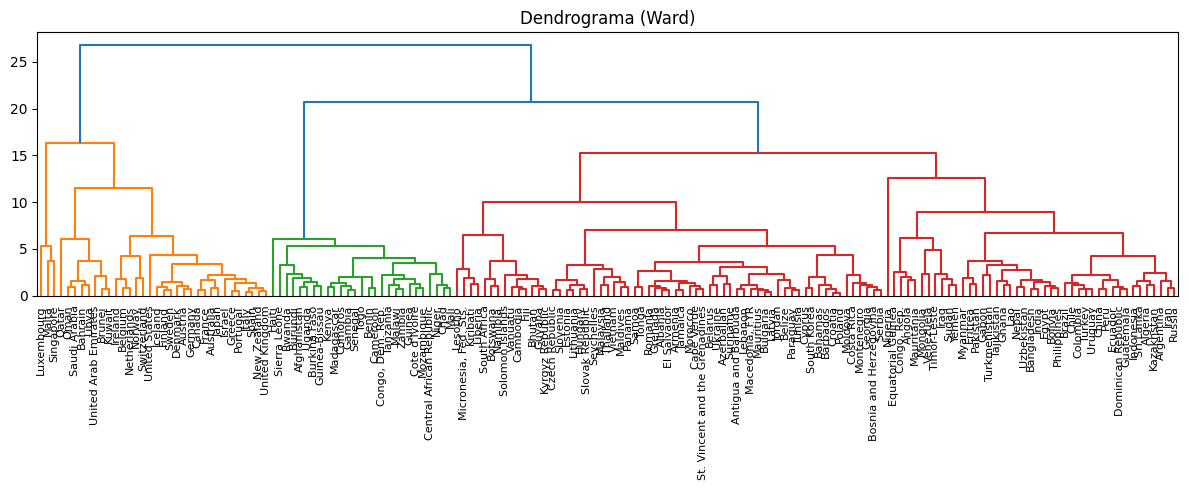

In [24]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(Z, labels=countries, leaf_rotation=90, leaf_font_size=8, color_threshold=None)
plt.title("Dendrograma (Ward)")
plt.tight_layout()
plt.show()

# Cortar em k=3 clusters para comparar
labels_hc = fcluster(Z, t=3, criterion='maxclust') - 1 

In [25]:
# Comparação simples entre K-Means e Hierárquico
import pandas as pd
comp = pd.DataFrame({
    'country': countries,
    'kmeans': labels_km,
    'hierarchical': labels_hc
})
comp.head(10)

,country,kmeans,hierarchical
0,Afghanistan,1,1
1,Albania,2,2
2,Algeria,2,2
3,Angola,1,2
4,Antigua and Barbuda,2,2
5,Argentina,2,2
6,Armenia,2,2
7,Australia,0,0
8,Austria,0,0
9,Azerbaijan,2,2


## Parte 4 — Algoritmos

### 4.1 Passos do K-Means (até convergência)
1. **Inicialização:** escolher `k` centróides iniciais (aleatórios ou k-means++).  
2. **Atribuição:** atribuir cada ponto ao centróide mais próximo.  
3. **Atualização:** recalcular cada centróide como a média dos pontos do seu cluster.  
4. **Convergência:** repetir 2–3 até que os centróides mudem abaixo de um limite mínimo ou atinja `max_iter`.

### 4.2 Versão com **Medóide** (baricentro substituído pelo ponto real mais próximo)
- Em cada iteração, após formar os clusters, o **representante** de cada cluster passa a ser o **medóide** (amostra real mais próxima ao *centro* do cluster).  
- Isso reduz sensibilidade a *outliers* (em relação ao centróide média), aproximando-se do **K-Medóides**.

In [26]:
# Exemplo didático: rodar K-Medóides (PAM) usando a implementação do diretório src
import sys, os
sys.path.append(os.path.abspath("../src"))
from kmedoids import KMedoids

kmed = KMedoids(n_clusters=3, max_iter=100, metric='euclidean', random_state=42).fit(X_scaled)
labels_kmed = kmed.labels_
medoid_indices = kmed.medoid_indices_
kmed.inertia_, medoid_indices, countries[medoid_indices]

(334.213544643036,
 array([147, 152,  53]),
 array(['Tanzania', 'Tunisia', 'Finland'], dtype=object))